# Generative Model Project
Yassine Ben Jemaa
Irshath Nagouri

# Dataset 


In [294]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = './data_train_log_return.csv'
data_train_log_return = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
data_train_log_return.head()


,0,0.01249535315117,0.0111256706670408,0.0032520459252687,0.0066249108779032
0,1,0.011439,0.002691,0.001206,0.006947
1,2,0.000632,0.007277,0.004049,0.000074
2,3,0.017828,0.028210,0.007758,0.007382
3,4,0.021115,0.019642,0.009238,0.011499
4,5,0.001177,0.002096,0.001348,0.004966


In [295]:
df = data_train_log_return
df = df.drop(columns = ["0"])
df = df.rename(columns={'0.01249535315117': 'f1', '0.0111256706670408': 'f2', '0.0032520459252687': 'f3', '0.0066249108779032': 'f4'})
df
#df = df.rename(columns = {"f1", "f2", "f3", "f4"})

,f1,f2,f3,f4
0,0.011439,0.002691,0.001206,0.006947
1,0.000632,0.007277,0.004049,0.000074
2,0.017828,0.028210,0.007758,0.007382
3,0.021115,0.019642,0.009238,0.011499
4,0.001177,0.002096,0.001348,0.004966
...,...,...,...,...
740,0.001938,0.008833,0.003927,0.005106
741,0.005003,0.018943,0.003057,0.001988
742,0.007683,0.001958,0.007002,0.006467
743,0.003396,0.001280,0.007621,0.001680


In [296]:
num_samples_f1_less_than_0_001 = df[(df['f1'] < 0.001) | (df['f2'] < 0.001)].shape[0]
print(f"Number of samples with f1 or f2 < 0.001: {num_samples_f1_less_than_0_001}")


Number of samples with f1 or f2 < 0.001: 73


In [297]:
df_train_400 = df.iloc[:444]
df_test_300 = df.iloc[445:]
same_samples = df_train_400.index.equals(df_test_300.index)
print(f"Same samples: {same_samples}")
df_test_300.shape

Same samples: False


(300, 4)

# VAE implementation and Training


In [298]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the dimensions and hyperparameters
original_dim = df.shape[1]   # minus 1 to exclude the index column
latent_dim = 3  # Dimension of the latent space
sigma = 1 # Hyperparameter that defines the strength of the regularization term

# Encoder
inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(256, activation='elu')(inputs) # Input Layer
x = layers.Dense(128, activation='leaky_relu')(x) # Input Layer
x = layers.Dense(64, activation='leaky_relu')(x) # Input Layer
x = layers.Dense(32, activation='leaky_relu')(x) # Dense Layer
x = layers.Dense(16, activation='leaky_relu')(x) # Dense Layer
x = layers.Dense(8, activation='leaky_relu')(x) # Dense Layer
x = layers.Dense(4, activation='linear')(x) # Dense Layer
z_mean = layers.Dense(latent_dim)(x) # output Layer
z_log_var = layers.Dense(latent_dim)(x) # output Layer

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon # Reparameterization trick
z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(4, activation='elu')(decoder_input)
x = layers.Dense(16, activation='leaky_relu')(x)
x = layers.Dense(32, activation='leaky_relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='elu')(x) # Input Layer



decoder_output = layers.Dense(original_dim, activation='linear')(x)

# Models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoder_output, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)/(2*sigma**2)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)





# Add the loss function to the VAE model
vae.add_loss(vae_loss)
# Compile the VAE model with the optimizer and the loss function
vae.compile(optimizer='adam')


# For the WAE Loss: 
##
Lambda = 0.01

def second_wasserstein_distance(mu, nu, sigma_mu, sigma_nu):
    # Compute the trace term
    trace_term = tf.linalg.trace(tf.linalg.matmul(sigma_mu, sigma_nu))

    # Compute the mean term
    mean_term = tf.reduce_mean(tf.square(mu - nu))

    # Compute the second Wasserstein distance
    wasserstein_distance = trace_term + mean_term

    return wasserstein_distance

weiss = second_wasserstein_distance(z_mean, tf.zeros([latent_dim]), z_log_var, tf.eye(latent_dim))
wae_loss = tf.reduce_mean(reconstruction_loss - Lambda * weiss)
##


# Displaying the model summary
encoder.summary(), decoder.summary(), vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 dense_243 (Dense)           (None, 256)                  1280      ['input_35[0][0]']            
                                                                                                  
 dense_244 (Dense)           (None, 128)                  32896     ['dense_243[0][0]']           
                                                                                                  
 dense_245 (Dense)           (None, 64)                   8256      ['dense_244[0][0]']           
                                                                                            

(None, None, None)

In [299]:
import numpy as np
#Gradient Descent


vae.fit(df, epochs=20, batch_size=32)

# Generate new data
z_sample = np.random.normal(size=(410, latent_dim)) # Generate latent space points that are normally distributed
generated_data = decoder.predict(z_sample) 

# Save the generated data
pd.DataFrame(generated_data).to_csv('generate_VAE.csv', index=False)
pd.DataFrame(z_sample).to_csv('noise.csv', index=False)
# Save the entire model
vae.save('vae_model.h5')




Epoch 1/20
24/24 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 2/20
24/24 [==============================] - 0s 2ms/step - loss: 6.4324e-04
Epoch 3/20
24/24 [==============================] - 0s 2ms/step - loss: 3.6870e-04
Epoch 4/20
24/24 [==============================] - 0s 2ms/step - loss: 2.9985e-04
Epoch 5/20
24/24 [==============================] - 0s 2ms/step - loss: 2.8330e-04
Epoch 6/20
24/24 [==============================] - 0s 2ms/step - loss: 2.8594e-04
Epoch 7/20
24/24 [==============================] - 0s 2ms/step - loss: 3.2033e-04
Epoch 8/20
24/24 [==============================] - 0s 2ms/step - loss: 2.8828e-04
Epoch 9/20
24/24 [==============================] - 0s 2ms/step - loss: 2.7889e-04
Epoch 10/20
24/24 [==============================] - 0s 4ms/step - loss: 2.6344e-04
Epoch 11/20
24/24 [==============================] - 0s 2ms/step - loss: 2.7038e-04
Epoch 12/20
24/24 [==============================] - 0s 2ms/step - loss: 2.6413e-04
Epoch

/Users/yass/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Vizualization 

24/24 [==============================] - 0s 773us/step


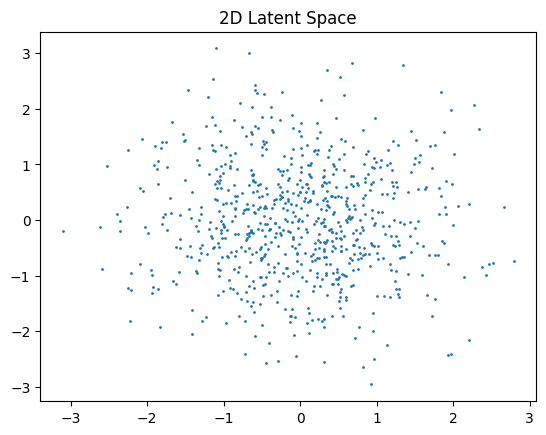

In [300]:
import matplotlib.pyplot as plt  
z_values = encoder.predict(df)[2]

plt.scatter(z_values[:, 0], z_values[:, 1], s=1)
plt.title('2D Latent Space')


plt.show()



In [303]:
ori_data = df.iloc[:410]
ori_data = ori_data.to_numpy()
print(type(ori_data))

<class 'numpy.ndarray'>


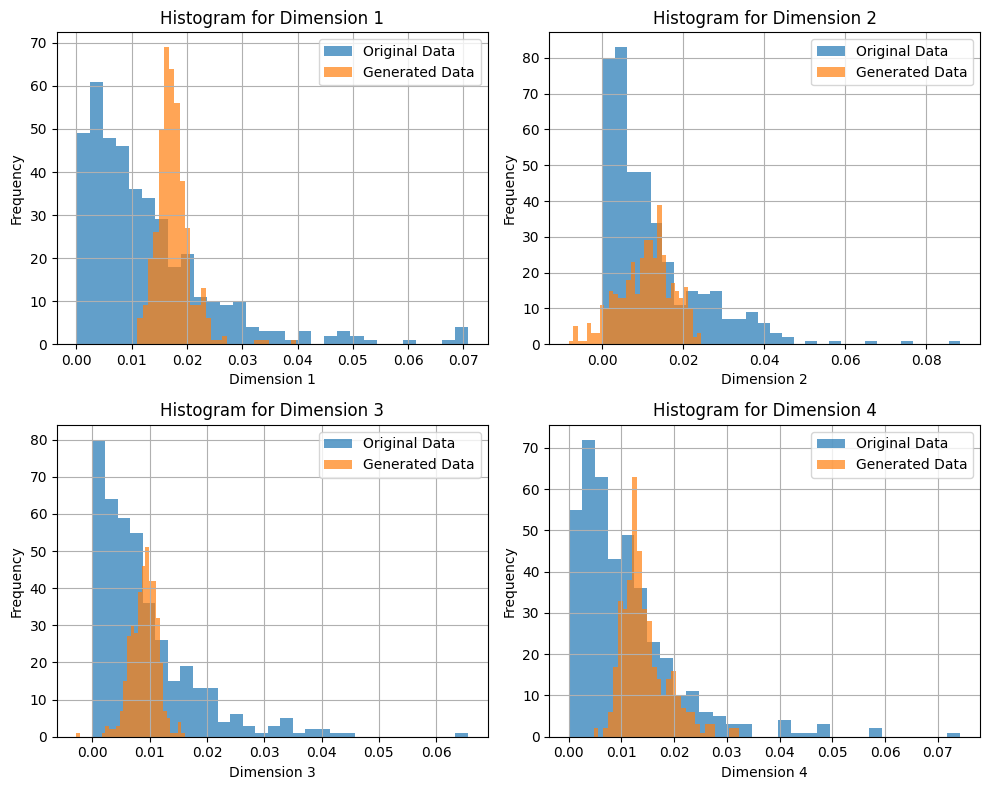

In [304]:
num_variables = 746
dimension = 4
data = ori_data

# Create subplots in a 2x2 grid for each dimension
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for dim in range(dimension):
    row = dim // 2  # Determine the row index
    col = dim % 2   # Determine the column index
    axs[row, col].hist(data[:, dim], bins=30, alpha=0.7, label='Original Data')
    axs[row, col].hist(generated_data[:, dim], bins=30, alpha=0.7, label='Generated Data')
    axs[row, col].set_xlabel(f'Dimension {dim+1}')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'Histogram for Dimension {dim+1}')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()


# Metrics Evaluation 

In [305]:
# Anderson-Darling Distance
def anderson_darling_distance(generated_array, original_array):

    def indice(a, b):
        indice = int(a <= b)  
        return indice

    def u_i(X,Y):
        n=len(X)
        X.sort()
        l=[]
        for i in range(n):
            l.append((1/(n+2))*(sum(indice(y,X[i]) for y in Y)+1))
        return l
    
    def W(X,Y):
        # Wn is a statistic that measures the distance between the empirical distribution function of the sample and the theoretical distribution function
        n=len(X)
        u=u_i(X,Y)
        w_n=-n-(1/n)*sum(((2*i-1)*(np.log(u[i-1])+np.log(1-u[n-i]))) for i in range(1,n+1)) 
        return w_n

    def anderson_darling(x,y):
        # For the final Anderson-Darling distance, we average the Wn values for each feature
        d=x.shape[1]
        W_n=(1/d)*sum(W(x[i],y[i]) for i in range(d))
        return W_n


    return anderson_darling(generated_array, original_array)

anderson_darling_distance(generated_data, ori_data)

1.1113128618497

In [306]:
#Absolute Kendall error
import numpy as np

# Function to calculate Z_i for a dataset
def calculate_zi(data):
    n, d = data.shape
    zi = np.zeros(n)
    for i in range(n):
        for j in range(n):
            if j != i:
                zi[i] += np.sum(data[j, :] < data[i, :])
        zi[i] /= (n - 1) * d
    return zi

# Function to calculate the Absolute Kendall error between two datasets
def absolute_kendall_error(data1, data2):
    # Ensure the datasets have the same size
    if data1.shape != data2.shape:
        raise ValueError("Datasets must have the same size")
    
    # Calculate Z_i for both datasets
    zi_data1 = calculate_zi(data1)
    zi_data2 = calculate_zi(data2)
    
    # Compute the L1 norm of the difference between the Z_i vectors
    absolute_error = np.mean(np.abs(zi_data1 - zi_data2))
    return absolute_error



# Calculate the Absolute Kendall error
error = absolute_kendall_error(ori_data, generated_data)
print(f"Absolute Kendall error: {error}")


Absolute Kendall error: 0.22743753354403956


# Load the Model

In [ ]:
from keras.models import load_model
vae2 = load_model('vae_model.h5', compile = False)
file_path = './noise.csv'
noise = pd.read_csv(file_path)
noise = noise.to_numpy()

In [ ]:
vae2.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 3),                  177838    ['input_7[0][0]']             
                              (None, 3),                                                          
                              (None, 3)]                                                          
                                                                                                  
 decoder (Functional)        (None, 4)                    11556     ['encoder[0][2]']             
                                                                                                

In [ ]:
vae2.compile(optimizer='adam')


In [ ]:
latent_dim = 3

z_sample = noise # Generate latent space points that are normally distributed
generated_data2 = decoder.predict(z_sample) 

13/13 [==============================] - 0s 626us/step


In [ ]:
anderson_darling_distance(generated_data2, ori_data)

1.9832933366289376